In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 150
rcParams["figure.dpi"] = 150

In [2]:
import corner
import emcee3
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from astropy.stats import LombScargle

In [3]:
import celerite
from celerite import terms

from rotate.k2 import get_light_curve
from rotate.rotation_term import RotationTerm, MixtureTerm, MixtureOfSHOsTerm

Download a light curve.

In [4]:
# sections, t, flux = get_light_curve(2, 205117205)  # rotation
# print(len(t))

In [32]:
import kepler_data as kd
import kplr
client = kplr.API()

kepid = 4760478
kepstar = client.star(kepid)
kepstar.get_light_curves(fetch=True, short_cadence=False)

LC_DIR = "/Users/ruthangus/.kplr/data/lightcurves/{}".format(str(kepid).zfill(9))
sections, t, flux, flux_err = kd.load_kepler_data(LC_DIR)
m = 5000
sections, t, flux = sections[:m], t[:m], flux[:m]
flux *= 1e4

print(len(t))

5000


In [33]:
flux0 = np.array(flux) - np.mean(flux)  # Mean subtract

# Fit and remove straight line trend for the periodogram.
A = np.vander(t - np.mean(flux), 4)
w = np.linalg.solve(np.dot(A.T, A), np.dot(A.T, flux))
trend = np.dot(A, w)

# First guess at the period
min_period, max_period = 0.1, 30.0

# Compute periodogram.
freq = np.linspace(1.0 / max_period, 1.0 / min_period, 5000)
model = LombScargle(t, flux - trend)
power = model.power(freq, method="fast", normalization="psd")
power /= len(t)
power0 = np.array(power)

# Filter (reduce amplitudes at low frequencies)
freq0 = 1.0 / 10.0
filt = 1.0 / np.sqrt(1 + (freq0 / freq) ** (2*3))

power *= filt
#plt.plot(freq, filt)

Find highest peak

In [34]:
period = 1.0 / freq[np.argmax(power)]
print(period, "days")

9.514051893675063 days


Plot light curve and periodogram

/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


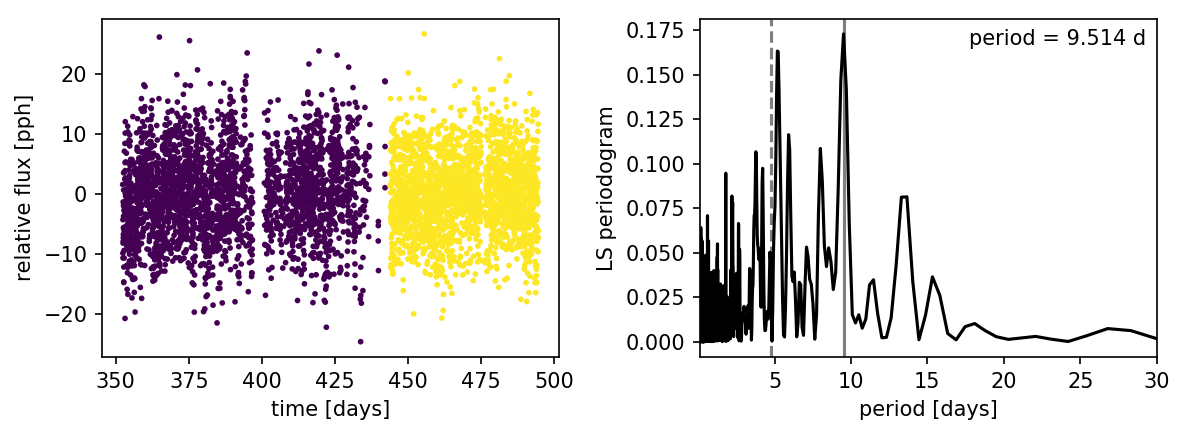

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].scatter(t, flux, c=sections, s=3)
axes[0].set_ylabel("relative flux [pph]")
axes[0].set_xlabel("time [days]")

axes[1].plot(1.0 / freq, power, "k")
axes[1].axvline(period, color="k", alpha=0.5)
axes[1].axvline(0.5 * period, color="k", ls="dashed", alpha=0.5)
axes[1].set_xlabel("period [days]")
axes[1].set_ylabel("LS periodogram")
axes[1].annotate("period = {0:.3f} d".format(period), xy=(1, 1), xycoords="axes fraction",
                 ha="right", va="top", xytext=(-5, -5), textcoords="offset points")

axes[1].set_xlim(min_period, max_period)

fig.set_tight_layout(True)

Define the Celerite kernel

In [36]:
print(np.log(period), np.log(min_period), np.log(max_period))
print(np.allclose(t, np.sort(t)))

2.2527698524491835 -2.3025850929940455 3.4011973816621555
True


In [37]:
log_var = np.log(np.var(flux))
print(log_var)
print(np.var(flux))

3.7888389
44.205048


In [38]:
kernel = MixtureTerm(
    log_a1=log_var,
    log_b1=-0.1,
    log_f1=-5.0,
    log_P=np.log(period),
    mix_par=-1.0,
    log_b2=-0.1,
    log_f2=-5.0,
    bounds=dict(
        log_a1=(-10.0, 10.0),
        log_b1=(-5.0, 5.0),
        log_f1=(-5.0, 5.0),
        log_P=(np.log(min_period), np.log(max_period)),
        mix_par=(-5.0, 5.0),
        log_b2=(-5.0, 5.0),
        log_f2=(-5.0, 5.0),
    ),
)

kernel += terms.SHOTerm(
    log_S0=log_var,
    log_Q=-0.5*np.log(2),
    log_omega0=np.log(2*np.pi/10.0),
    bounds=dict(
        log_S0=(-20.0, 20.0),
        log_omega0=(np.log(2*np.pi/80.0), np.log(2*np.pi/2.0))
    )
)
kernel.terms[1].freeze_parameter("log_Q")

kernel += terms.JitterTerm(log_sigma=np.log(np.median(np.abs(np.diff(flux)))),
                           bounds=[(-10.0, 10.0)])
mean = celerite.modeling.ConstantModel(np.mean(flux), bounds=[(-5000.0, 5000.0)])
mean.freeze_parameter("value")
gp = celerite.GP(kernel, mean=mean)
gp.compute(t)

In [39]:
import numpy as np
from scipy.linalg import cho_factor, cho_solve

from celerite import modeling

class PolynomialModel(modeling.ModelSet):

    def __init__(self, gp, sections, t, y, order=3):
        self.t = t
        self.y = y
        
        A = np.vander((t - np.mean(t)) / (np.max(t) - np.min(t)), order)
        sections = np.atleast_1d(sections)
        s = np.unique(sections)
        self.A = np.zeros((len(t), order*len(s)))
        for i in s:
            m = sections == i
            self.A[m, order*i:order*i+order] = A[m]
        
        self.AT = self.A.T
        super(PolynomialModel, self).__init__([("gp", gp)])

    def get_weights(self):
        gp = self.models["gp"]
        gp.compute(self.t)
        alpha = gp.apply_inverse(self.y)[:, 0]
        KinvA = gp.apply_inverse(self.A)
        S = np.dot(self.AT, KinvA)
        S[np.diag_indices_from(S)] += 1e-8
        factor = cho_factor(S, overwrite_a=True, check_finite=False)
        ATalpha = np.dot(self.AT, alpha)
        return cho_solve(factor, ATalpha, overwrite_b=True, check_finite=False), alpha

    def alpha(self):
        gp = self.models["gp"]
        gp.compute(self.t)
        alpha = gp.apply_inverse(self.y)[:, 0]
        KinvA = gp.apply_inverse(self.A)
        S = np.dot(self.AT, KinvA)
        S[np.diag_indices_from(S)] += 1e-8

        factor = cho_factor(S, overwrite_a=True, check_finite=False)
        half_log_det = 0.5 * gp.solver.log_determinant()
        half_log_det += np.sum(np.log(np.diag(factor[0])))

        ATalpha = np.dot(self.AT, alpha)
        term2 = np.dot(KinvA, cho_solve(factor, ATalpha,
                                        check_finite=False, overwrite_b=True))

        half_log_det = 0.5 * gp.solver.log_determinant()
        half_log_det += np.sum(np.log(np.diag(factor[0])))

        return alpha - term2, half_log_det

    def log_marginalized_likelihood(self):
        try:
            alpha, half_log_det = self.alpha()
        except (celerite.solver.LinAlgError, np.linalg.LinAlgError):
            return -np.inf
        return -0.5*np.dot(self.y, alpha) - half_log_det

    def get_trend(self):
        w, _ = self.get_weights()
        return np.dot(self.A, w)
    
    def predict(self):
        gp = self.models["gp"]
        w, alpha = self.get_weights()
        resid = self.y - np.dot(self.A, w)
        return self.y - gp.kernel.jitter * gp.apply_inverse(resid)[:, 0]

OPTIMISE

In [40]:
model = PolynomialModel(gp, sections, t, flux)
model.log_marginalized_likelihood()

def nll(params):
    model.set_parameter_vector(params)
    try:
        return -model.log_marginalized_likelihood()
    except celerite.solver.LinAlgError:
        return 1e10

# Period selection
gp.freeze_parameter("kernel:terms[0]:log_P")
p0 = gp.get_parameter_vector()
log_P0 = gp.get_parameter("kernel:terms[0]:log_P")
best = (np.inf, p0)
for log_period in log_P0 + np.log([0.5, 1.0, 2.0]):
    if not np.allclose(log_period, log_P0) and not (2*min_period < np.exp(log_period) < max_period):
        continue
    gp.set_parameter("kernel:terms[0]:log_P", log_period)
    gp.freeze_parameter("kernel:terms[0]:log_P")
    bounds = gp.get_parameter_bounds()
    soln = minimize(nll, p0, method="L-BFGS-B", bounds=bounds)
    gp.set_parameter_vector(soln.x)

    gp.thaw_parameter("kernel:terms[0]:log_P")
    bounds = gp.get_parameter_bounds()
    soln = minimize(nll, gp.get_parameter_vector(), method="L-BFGS-B", bounds=bounds)
    gp.set_parameter_vector(soln.x)
    
    print(np.exp(gp.get_parameter("kernel:terms[0]:log_P")), soln.fun, soln.success)
    if soln.fun < best[0]:
        best = soln.fun, soln.x

gp.set_parameter_vector(best[1])

flux = flux0 - model.get_trend()

4.75702398562292 11793.403902228069 True
9.52755699771299 11792.185595757219 True
19.028102359546256 11793.403587572766 True


In [41]:
gp.get_parameter_dict()

OrderedDict([('kernel:terms[0]:log_a1', -0.13288748162255712),
             ('kernel:terms[0]:log_b1', -0.4522262439766867),
             ('kernel:terms[0]:log_f1', -5.0),
             ('kernel:terms[0]:log_P', 2.2541883361896513),
             ('kernel:terms[0]:mix_par', -4.6700958321273855),
             ('kernel:terms[0]:log_b2', 1.7415387914560536),
             ('kernel:terms[0]:log_f2', -4.966583929515238),
             ('kernel:terms[1]:log_S0', 1.2532316376701056),
             ('kernel:terms[1]:log_omega0', 0.8092280266297084),
             ('kernel:terms[2]:log_sigma', 1.8324332886680919)])

Plot the psd of each celerite term.

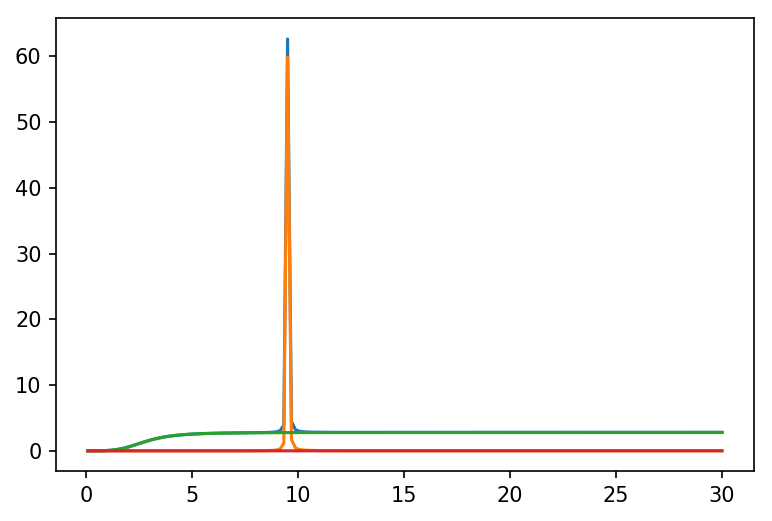

In [42]:
omega = 2 * np.pi * freq
plt.plot(1./freq, gp.kernel.get_psd(omega))
for term in gp.kernel.terms:
    plt.plot(1./freq, term.get_psd(omega))

In [43]:
sigma_mask = np.ones(len(t), dtype=bool)

def nll(params):
    gp.set_parameter_vector(params)
    try:
        gp.compute(t[sigma_mask])
    except celerite.solver.LinAlgError:
        return 1e10, np.zeros_like(params)
    grad = gp.grad_log_likelihood(flux[sigma_mask])
    return -grad[0], -grad[1]

gp.thaw_parameter("mean:value")
gp.freeze_parameter("kernel:terms[0]:log_P")
p0 = gp.get_parameter_vector()
log_P0 = gp.get_parameter("kernel:terms[0]:log_P")
best = (np.inf, p0)
for log_period in log_P0 + np.log([0.5, 1.0, 2.0]):
    if not np.allclose(log_period, log_P0) and not (2*min_period < np.exp(log_period) < max_period):
        continue
    gp.set_parameter("kernel:terms[0]:log_P", log_period)
    gp.freeze_parameter("kernel:terms[0]:log_P")
    bounds = gp.get_parameter_bounds()
    soln = minimize(nll, p0, jac=True, method="L-BFGS-B", bounds=bounds)
    gp.set_parameter_vector(soln.x)

    gp.thaw_parameter("kernel:terms[0]:log_P")
    bounds = gp.get_parameter_bounds()
    soln = minimize(nll, gp.get_parameter_vector(), jac=True, method="L-BFGS-B", bounds=bounds)
    gp.set_parameter_vector(soln.x)
    
    print(np.exp(gp.get_parameter("kernel:terms[0]:log_P")), soln.fun, soln.success)
    if soln.fun < best[0]:
        best = soln.fun, soln.x

gp.set_parameter_vector(best[1])

# Sigma clipping
for i in range(10):
    bounds = gp.get_parameter_bounds()
    soln = minimize(nll, gp.get_parameter_vector(), jac=True, method="L-BFGS-B", bounds=bounds)
    gp.set_parameter_vector(soln.x)

    mu, var = gp.predict(flux[sigma_mask], t, return_var=True)
    m = np.abs(flux - mu) < 7 * np.sqrt(var)
    print(m.sum(), sigma_mask.sum())
    if m.sum() == sigma_mask.sum():
        break
    sigma_mask = m
gp.compute(t[sigma_mask])

import copy
map_gp = copy.deepcopy(gp)

/Users/ruthangus/anaconda/lib/python3.5/site-packages/autograd/numpy/numpy_extra.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return A[idx]


4.763777755103958 11812.993532493758 True
9.529247595760348 11812.380287945038 True
19.055102835781444 11812.994234028096 True
3892 5000
3171 3892
2922 3171
2916 2922
2967 2916
3034 2967
3106 3034
3190 3106
3239 3190
3286 3239


Plot the GP prediction.

Text(-5,-5,'period = 8.516 d')

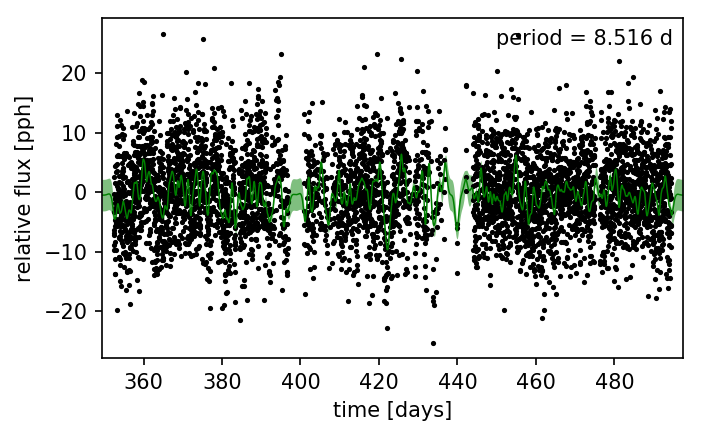

In [44]:
x = np.linspace(t.min() - 3, t.max() + 3, 5000)
pred_mu, pred_var = gp.predict(flux[sigma_mask], x, return_var=True)
pred_sig = np.sqrt(pred_var)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(t, flux, ".k", ms=3)
ax.plot(x, pred_mu, "g", lw=0.7)
ax.fill_between(x, pred_mu+pred_sig, pred_mu-pred_sig, color="g",
                alpha=0.5, lw=0)
ax.set_ylabel("relative flux [pph]")
ax.set_xlabel("time [days]")
ax.set_xlim(x.min(), x.max())

ml_period = np.exp(gp.kernel.terms[0].log_P)
ax.annotate("period = {0:.3f} d".format(ml_period),
            xy=(1, 1), xycoords="axes fraction",
            ha="right", va="top", xytext=(-5, -5), textcoords="offset points")

In [45]:
gp.get_parameter_dict()

OrderedDict([('kernel:terms[0]:log_a1', -9.650128044886344),
             ('kernel:terms[0]:log_b1', -5.0),
             ('kernel:terms[0]:log_f1', -5.0),
             ('kernel:terms[0]:log_P', 2.1419026429138435),
             ('kernel:terms[0]:mix_par', -4.998360857015216),
             ('kernel:terms[0]:log_b2', 1.7576879865849984),
             ('kernel:terms[0]:log_f2', -4.999259399121486),
             ('kernel:terms[1]:log_S0', 1.247417224497467),
             ('kernel:terms[1]:log_omega0', 1.04895953007458),
             ('kernel:terms[2]:log_sigma', 1.0791731285851947),
             ('mean:value', -0.509060183172251)])

Plot samples from the covariance matrix with optimised parameters.

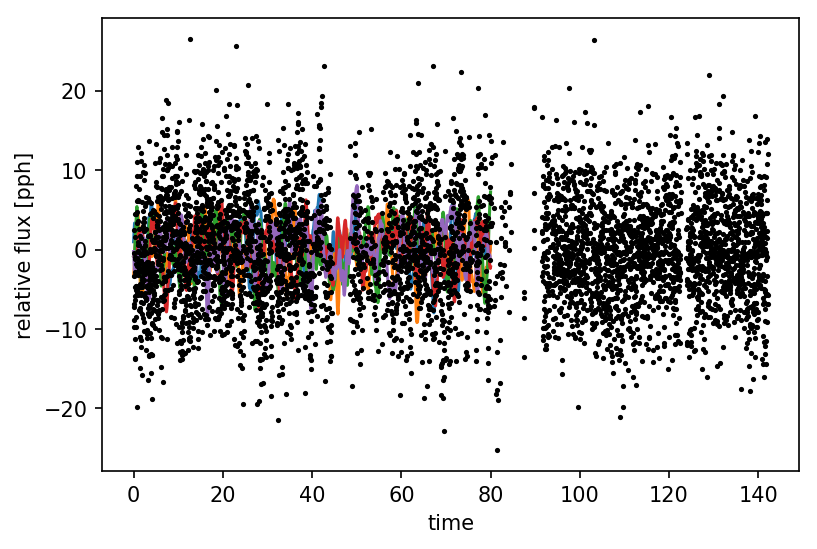

In [46]:
gp2 = celerite.GP(terms.TermSum(*(kernel.terms[:-1])))
x = np.linspace(0, 80, 1500)
gp2.compute(x, 1e-8)
y = gp2.sample(size=5)
plt.plot(x, y.T)
plt.plot(t - t.min(), flux, ".k", ms=3)
plt.xlabel("time")
plt.ylabel("relative flux [pph]")
plt.savefig("sims.png")

Plot the psd for each celerite term.

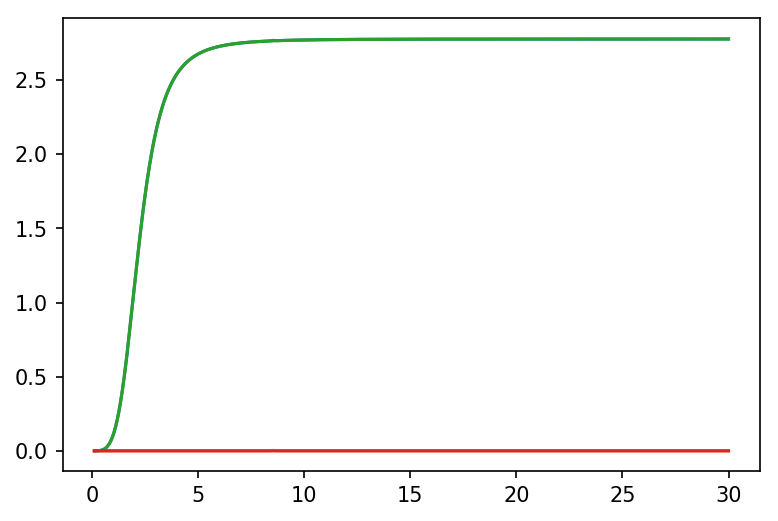

In [47]:
omega = 2 * np.pi * freq
plt.plot(1./freq, gp.kernel.get_psd(omega))
for term in gp.kernel.terms:
    plt.plot(1./freq, term.get_psd(omega))

Plot what the actual kernel looks like. (The covariance matrix moving away from the diagonal)

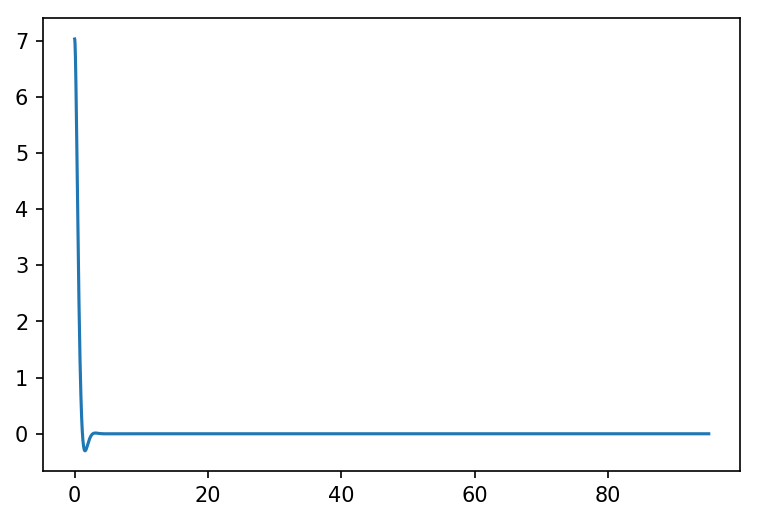

In [48]:
dt = np.linspace(0, period*10, 5000)
plt.plot(dt, gp.kernel.get_value(dt))

Now sample the posterior using emcee.

In [49]:
def log_prob(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    try:
        return lp + gp.log_likelihood(flux[sigma_mask])
    except celerite.solver.LinAlgError:
        return -np.inf

ndim = len(best[1])
nwalkers = 64
pos = best[1] + 1e-5 * np.random.randn(nwalkers, ndim)
lp = np.array(list(map(log_prob, pos)))
m = ~np.isfinite(lp)
while np.any(m):
    pos[m] = best[1] + 1e-5 * np.random.randn(m.sum(), ndim)
    lp[m] = np.array(list(map(log_prob, pos[m])))
    m = ~np.isfinite(lp)
    
sampler = emcee3.Sampler([
    emcee3.moves.StretchMove(),
    emcee3.moves.DEMove(1e-3),
    emcee3.moves.KDEMove(),
])  #, backend=emcee3.backends.HDFBackend("astero-{0}.h5".format(epicid)))

with emcee3.pools.InterruptiblePool() as pool:
    ensemble = emcee3.Ensemble(emcee3.SimpleModel(log_prob), pos,
                               pool=pool)
    ensemble = sampler.run(ensemble, 5000, progress=True)

100%|██████████| 5000/5000 [1:11:30<00:00,  1.17it/s]   


Plot the individual chains. Vertical blue lines show 5 x autocorrelation time.

/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee3-3.0.0.dev0-py3.5.egg/emcee3/autocorr.py:42: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee3-3.0.0.dev0-py3.5.egg/emcee3/autocorr.py:44: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee3-3.0.0.dev0-py3.5.egg/emcee3/autocorr.py:110: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the f

Final c is 1


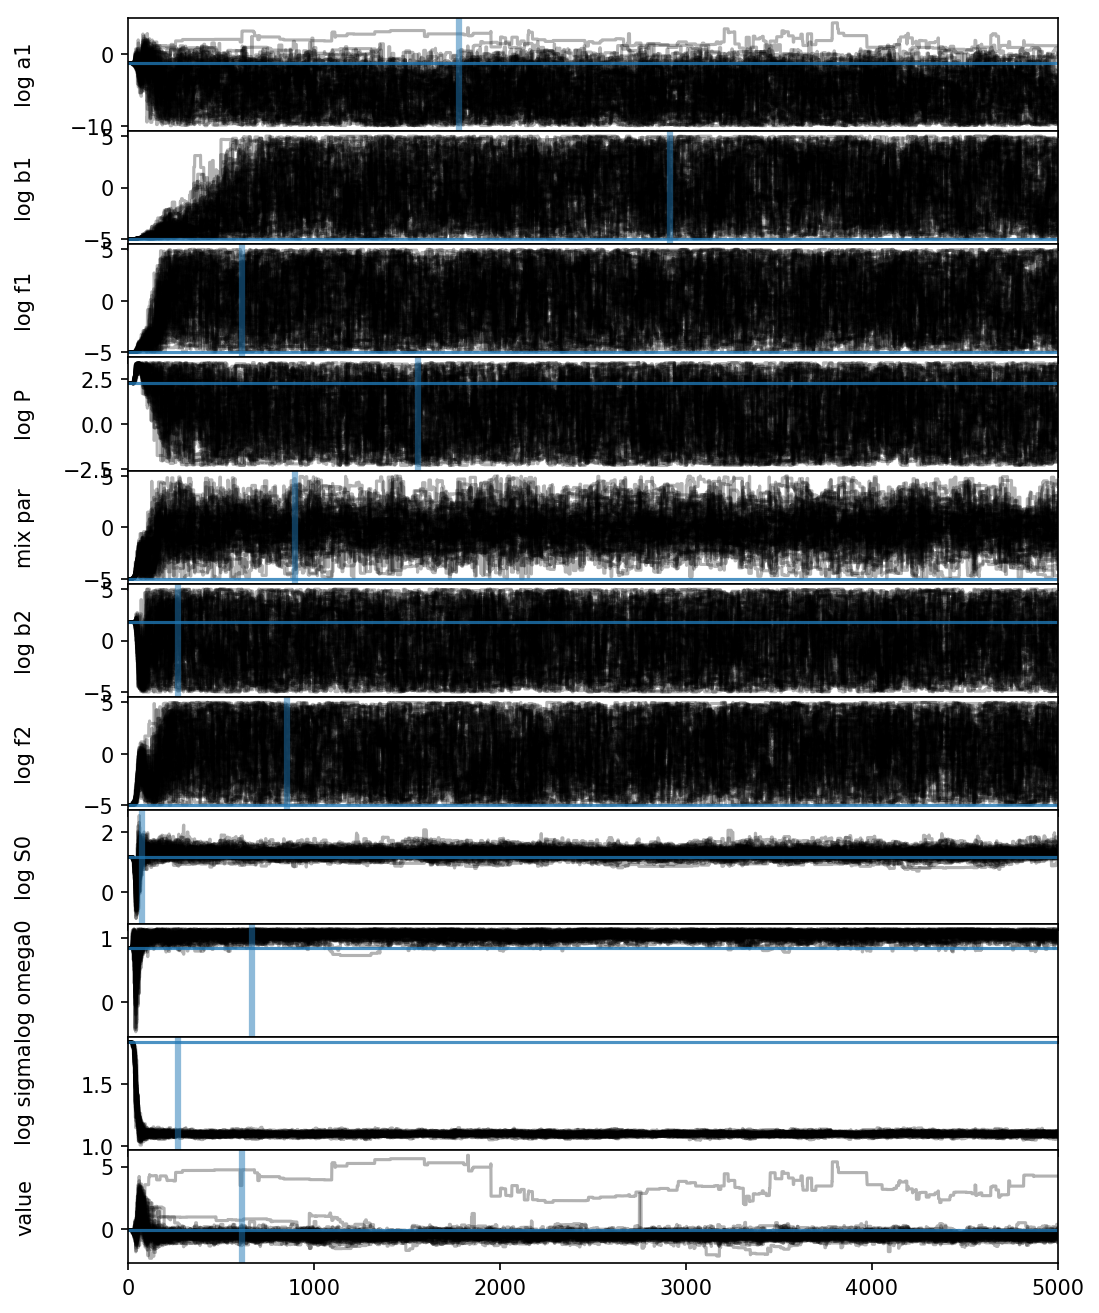

In [50]:
chain = sampler.get_coords()
names = gp.get_parameter_names()
names = [n.split(":")[-1].replace("_", " ") for n in names]
ndim = chain.shape[-1]

tau = 500 * np.ones(ndim)
for c in range(5, 0, -1):
    try:
        tau = sampler.get_integrated_autocorr_time(c=c)
    except emcee3.autocorr.AutocorrError:
        continue
    print("Final c is {0}".format(c))
    break
    
samples = sampler.get_coords(flat=True, discard=max(int(tau[3]*5), 1000))
logprob_chain = sampler.get_log_probability(flat=True, discard=max(int(tau[3]*5), 1000))

fig, axes = plt.subplots(ndim, 1, figsize=(8, ndim*1), sharex=True)
for i in range(ndim):
    ax = axes[i]
    ax.plot(chain[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(chain))
    ax.set_ylabel(names[i])
    ax.axvline(5*tau[i], alpha=0.5, lw=3)
    ax.axhline(best[1][i], alpha=0.8)
    ax.yaxis.set_label_coords(-0.1, 0.5)

fig.subplots_adjust(hspace=0)

Plot the marginals.

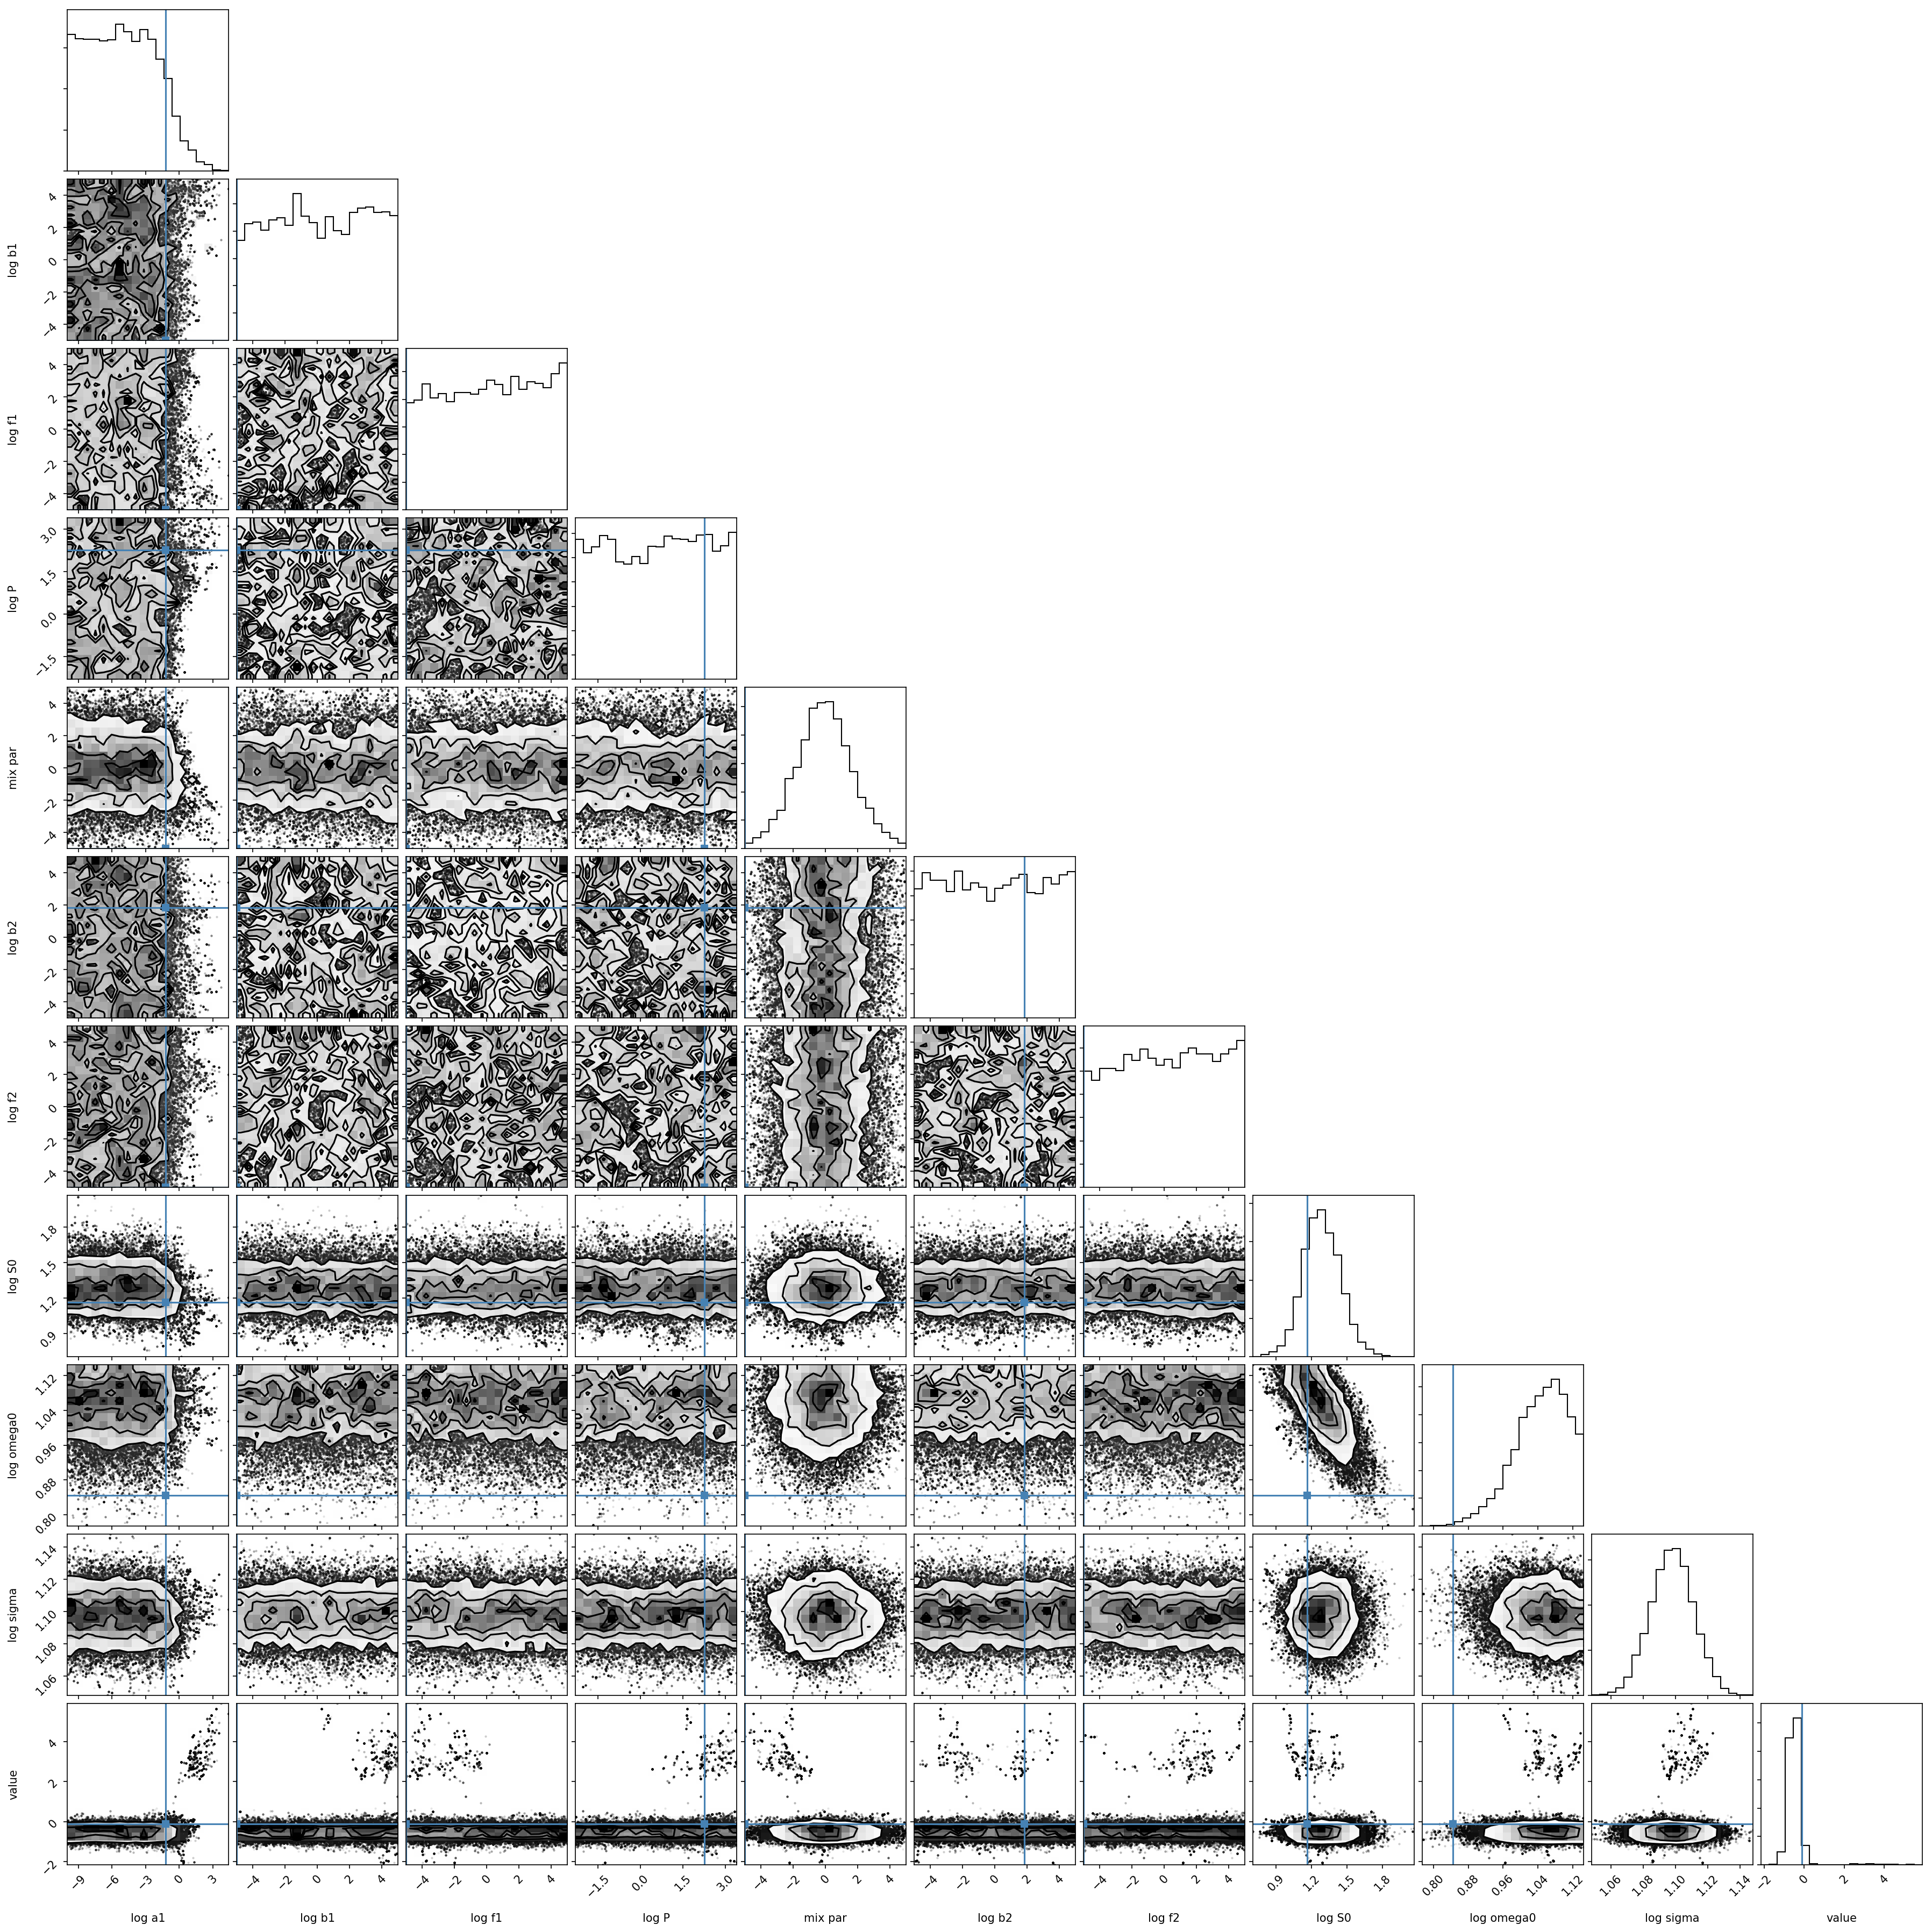

In [51]:
corner.corner(samples, truths=best[1], labels=names);

Plot a histogram of just the rotation period samples.

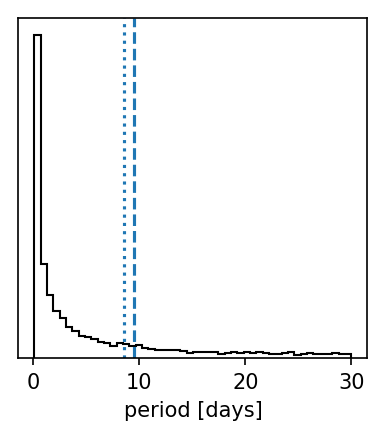

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

ax.hist(np.exp(samples[:, 3]), 50, color="k", histtype="step")
ax.axvline(period, ls="--")
ax.axvline(ml_period, ls=":")
ax.set_yticks([])
ax.set_xlabel("period [days]");

Plot the light curve, folded on the rotation period.

0.5763792278720193


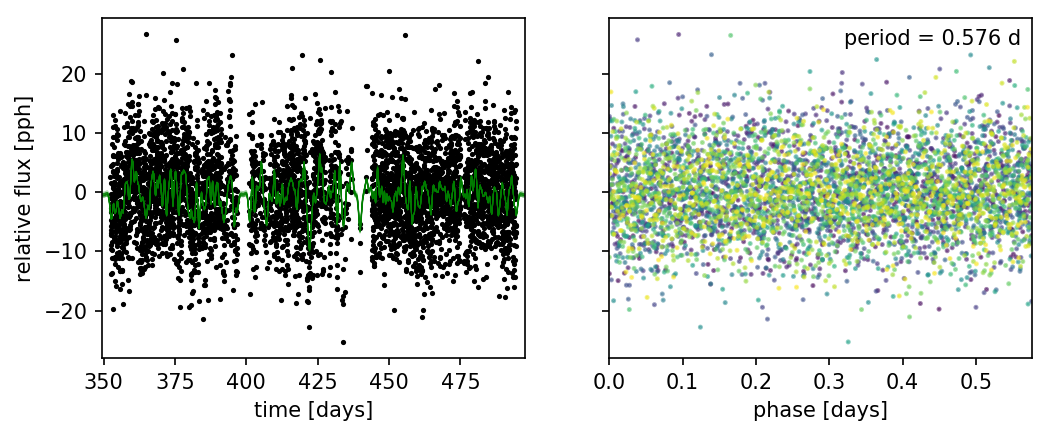

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

map_sample = samples[np.argmax(logprob_chain)]
map_period = np.exp(map_sample[3])
print(map_period)

ax1.plot(t, flux, ".k", ms=3)
ax2.scatter(t % map_period, flux, c=t, s=2, alpha=0.5)

x = np.linspace(t.min() - 3, t.max() + 3, 5000)
for s in samples[np.random.randint(len(samples), size=25)]:
    gp.set_parameter_vector(s)
    ax1.plot(x, gp.predict(flux[sigma_mask], x, return_cov=False), "g", alpha=0.3, lw=0.5)

ax2.annotate("period = {0:.3f} d".format(map_period),
             xy=(1, 1), xycoords="axes fraction",
             ha="right", va="top", xytext=(-5, -5), textcoords="offset points");
    
ax1.set_ylabel("relative flux [pph]")
ax1.set_xlabel("time [days]")
ax1.set_xlim(x.min(), x.max())
ax2.set_xlabel("phase [days]")
ax2.set_xlim(0, map_period);

Plot the covariance of each celerite term.

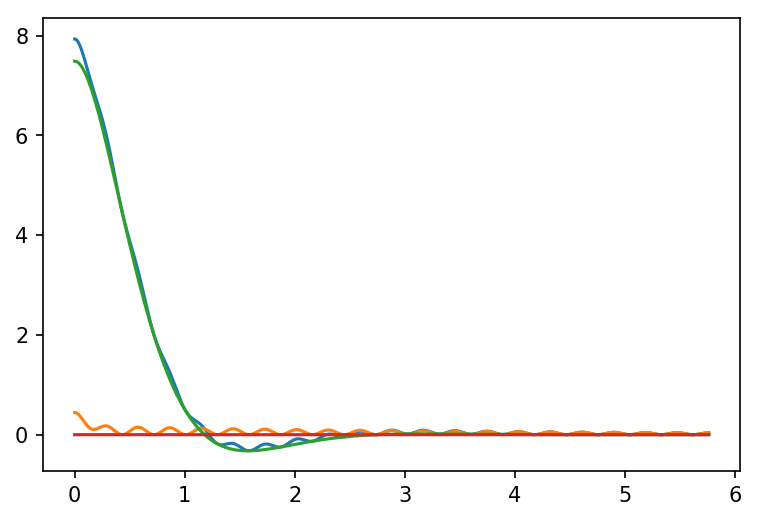

In [54]:
dt = np.linspace(0, map_period*10, 5000)
gp.set_parameter_vector(map_sample)
plt.plot(dt, gp.kernel.get_value(dt))
for term in gp.kernel.terms:
    plt.plot(dt, term.get_value(dt))

Plot the psd of each term.

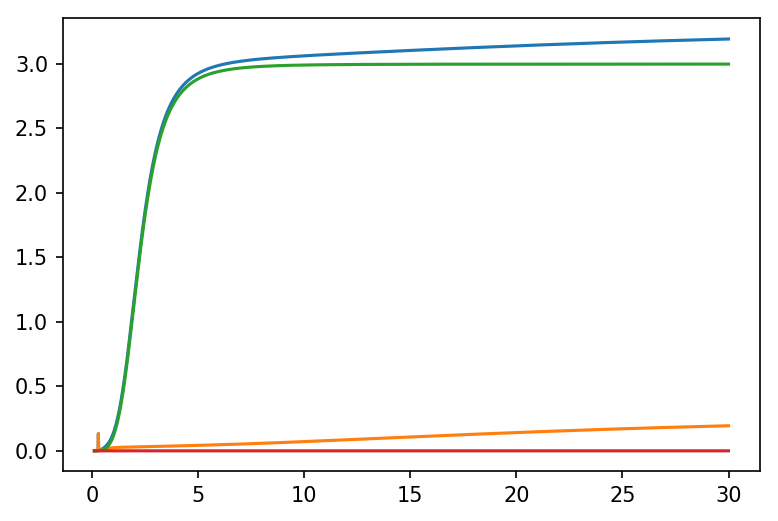

In [55]:
omega = 2 * np.pi * freq
plt.plot(1./freq, gp.kernel.get_psd(omega))
for term in gp.kernel.terms:
    plt.plot(1./freq, term.get_psd(omega))

In [ ]:
len(samples)

In [ ]:
import tqdm
K = 5000
stats = np.empty(K)
for i, s in tqdm.tqdm(enumerate(samples[np.random.randint(len(samples), size=K)])):
    gp.set_parameter_vector(s)
    gp.compute(t[sigma_mask])
    y_test = gp.sample()
    stats[i] = np.log(np.max(y_test) - np.min(y_test))  # np.log(np.var(y_test))
#     stats[i] = map_gp.log_likelihood(y_test)

In [ ]:
plt.hist(stats[np.isfinite(stats)], 100, histtype="step", color="k")
plt.axvline(np.log(np.max(flux[sigma_mask]) - np.min(flux[sigma_mask])), lw=2)
# plt.axvline(map_gp.log_likelihood(flux[sigma_mask]), lw=2)

In [ ]:
x = np.sort(stats[np.isfinite(stats)])
plt.plot(x, np.arange(len(x)) / len(x))
plt.axvline(np.log(np.max(flux[sigma_mask]) - np.min(flux[sigma_mask])))